## Determine which population each population-specific trancript is actually population specific to

In [116]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [117]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [118]:
# min_samples = 2
# min_cpm = 0.1
# min_tau = 0.8
# # tau_df = pd.read_csv(f'241023_{min_cpm}_{min_samples}tau.tsv', sep='\t')
# # tau_df = pd.read_csv(f'241031_med_{min_cpm}_tau.tsv', sep='\t')
# # min_samples = 2
# # min_cpm = 0.1
# # tau_df = pd.read_csv(f'241023_{min_cpm}_{min_samples}tau.tsv', sep='\t')
min_cpm = 1
min_samples = 1
min_tau = 0.8
# tau_df = pd.read_csv(f'241031_med_{min_cpm}_tau.tsv', sep='\t')
# tau_df.to_csv(f, sep='\t')
tau_df = pd.read_csv(f'241108_{min_cpm}_{min_samples}_mean_tau.tsv', sep='\t')
tau_df['tau_pop_spec_t'] = tau_df.tau>=min_tau
tau_df_back = tau_df.copy(deep=True)

In [119]:
# get median expression per population
# because this is what the value is computed based on 
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)

# get the median expression value across samples from the same populations
# using the median because we want to remove the effect 
# of individual samples expression patterns on the analysis
df = df.transpose()
df.reset_index(inplace=True)
df.rename({'index':'sample'}, axis=1, inplace=True)
df = df.merge(meta[['sample', 'population']], 
              how='left', on='sample')
# df = df.groupby('population').median().reset_index()
df = df.groupby('population').mean().reset_index()
df.set_index('population', inplace=True)
df.index.name = ''
df = df.transpose()

max_vals = df.max(axis=1)
max_pops = df.idxmax(axis=1)
max_count = (df == max_vals[:, None]).sum(axis=1)

df_copy = df.copy(deep=True)
df_copy[df.eq(max_vals, axis=0)] = float('NaN')
second_max_value = df_copy.max(axis=1)
second_max_column = df_copy.idxmax(axis=1)

df_copy = df.copy(deep=True)
df_copy[df.eq(max_vals, axis=0)] = float('NaN')
df_copy[df.eq(second_max_value, axis=0)] = float('NaN')
third_max_value = df_copy.max(axis=1)
third_max_column = df_copy.idxmax(axis=1)


df['max_val'] = max_vals
df['max_pop'] = max_pops
df['max_count'] = max_count
df['2_max_val'] = second_max_value
df['2_max_pop'] = second_max_column
df['3_max_val'] = third_max_value
df['3_max_pop'] = third_max_column
df['max_diffs'] = df['max_val']-df['2_max_val']
df['2_max_diffs'] = df['max_val']-df['3_max_val']

# remove all with >1 max count
n = len(df.loc[(df.max_count>1)&(df.max_count!=8)].index)
if n > 0: 
    print(f'Warning: found {n} transcripts with duplicate median exp. values across pops')
df = df.loc[df.max_count==1]



df.reset_index(inplace=True)
df.rename({'index':'tid'}, axis=1, inplace=True)
df.head()

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


,tid,AJI,CEU,HAC,ITU,LWK,MPC,PEL,YRI,max_val,max_pop,max_count,2_max_val,2_max_pop,3_max_val,3_max_pop,max_diffs,2_max_diffs
0,transcript_6675,0.364595,0.206081,0.348632,0.541199,0.459595,0.675766,0.694056,0.372693,0.694056,PEL,1,0.675766,MPC,0.541199,ITU,0.018291,0.152858
1,transcript_6676,0.850381,0.625232,0.564991,0.716487,0.513411,0.570094,0.515104,0.684088,0.850381,AJI,1,0.716487,ITU,0.684088,YRI,0.133894,0.166293
2,transcript_6684,0.688726,0.431695,0.393302,0.655868,0.597672,0.650575,0.622874,0.510741,0.688726,AJI,1,0.655868,ITU,0.650575,MPC,0.032859,0.038151
3,transcript_6687,0.039410,0.049406,0.033497,0.017817,0.000000,0.087052,0.068709,0.000000,0.087052,MPC,1,0.068709,PEL,0.049406,CEU,0.018343,0.037646
4,transcript_7913,0.000000,0.000000,0.008280,0.000000,0.000000,0.000000,0.000000,0.000000,0.008280,HAC,1,0.000000,AJI,NaN,NaN,0.008280,NaN


## save this as a table

In [122]:
tau_df_2 = pd.read_csv('241110_tau_1_min_cpm_0.8_min_tau.tsv', sep='\t')

In [125]:
tau_df_2 = tau_df_2.merge(df[['max_pop', 'tid']], 
                          how='left',
                          on='tid')
tau_df_2.head()

,Unnamed: 0,tid,tau,isoform,pop_spec_t,tau_pop_spec_t,max_pop
0,0,transcript_6675,0.701495,transcript_6675,False,False,PEL
1,1,transcript_6676,0.525534,transcript_6676,False,False,AJI
2,2,transcript_6684,0.594136,transcript_6684,False,False,AJI
3,3,transcript_11363,0.785230,transcript_11363,False,False,MPC
4,4,transcript_11368,0.694987,transcript_11368,False,False,LWK


In [126]:
tau_df_2.to_csv('241110_tau_1_min_cpm_0.8_min_tau_max_pop.tsv', sep='\t')

## Check concordance of population each method calls these as specific to

In [74]:
df.head()

,tid,AJI,CEU,HAC,ITU,LWK,MPC,PEL,YRI,max_val,max_pop,max_count,2_max_val,2_max_pop,3_max_val,3_max_pop,max_diffs,2_max_diffs
0,transcript_6675,0.364595,0.206081,0.348632,0.541199,0.459595,0.675766,0.694056,0.372693,0.694056,PEL,1,0.675766,MPC,0.541199,ITU,0.018291,0.152858
1,transcript_6676,0.850381,0.625232,0.564991,0.716487,0.513411,0.570094,0.515104,0.684088,0.850381,AJI,1,0.716487,ITU,0.684088,YRI,0.133894,0.166293
2,transcript_6684,0.688726,0.431695,0.393302,0.655868,0.597672,0.650575,0.622874,0.510741,0.688726,AJI,1,0.655868,ITU,0.650575,MPC,0.032859,0.038151
3,transcript_6687,0.039410,0.049406,0.033497,0.017817,0.000000,0.087052,0.068709,0.000000,0.087052,MPC,1,0.068709,PEL,0.049406,CEU,0.018343,0.037646
4,transcript_7913,0.000000,0.000000,0.008280,0.000000,0.000000,0.000000,0.000000,0.000000,0.008280,HAC,1,0.000000,AJI,NaN,NaN,0.008280,NaN


In [75]:
# get structural categories
## what structural categories are high-tau transcripts?
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)
mt_df = mt_df.loc[mt_df.pop_spec_t==True]

In [76]:
mt_df['det_pop'] = mt_df[get_population_colors()[1]].idxmax(axis=1)

In [77]:
temp = tau_df.merge(df[['tid', 'max_pop']], how='left',
                    on='tid')
temp = temp.merge(mt_df[['isoform', 'det_pop']], how='inner',
                left_on='tid',
                right_on='isoform')
# print(len(temp.loc[temp.tau_pop_spec_t == True]))
# print(len(temp.loc[temp.det_pop.isnull()]))

In [78]:
# limit to the intersection of tau pop spec and 
# detection population specific 
temp = temp.loc[temp.tau_pop_spec_t==True]
temp['same_pop_spec_pop'] = temp.max_pop==temp.det_pop
temp[['max_pop', 'det_pop', 'tau', 'same_pop_spec_pop']].head()
temp.loc[temp.max_pop!=temp.det_pop][['max_pop', 'det_pop', 'tau', 'same_pop_spec_pop']].head()
temp[['same_pop_spec_pop', 'tau']].groupby('same_pop_spec_pop').count()

,tau
same_pop_spec_pop,
False,33
True,81


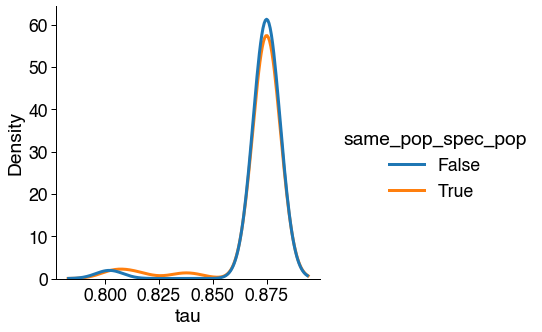

In [79]:
# plot tau values for the different ones
ax = sns.displot(temp, x='tau', hue='same_pop_spec_pop',
                 kind='kde', linewidth=3, common_norm=False)
# clean_figure(ax) 

## Which population pairs are the bad ones?

In [80]:
temp = temp.loc[temp.same_pop_spec_pop==False]
temp = temp[['max_pop', 'det_pop', 'tid']].groupby(['max_pop', 'det_pop']).nunique().reset_index().rename({'tid':'n_t'}, axis=1)


In [81]:
temp = temp.pivot(columns='det_pop', values='n_t', index='max_pop')

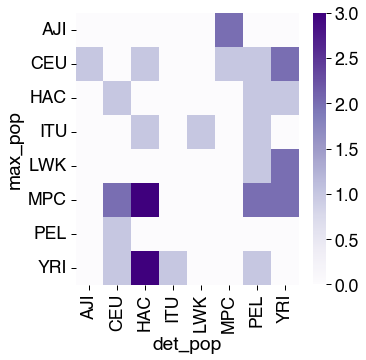

In [82]:
init_plot_settings(aspect='square')
temp.fillna(0, inplace=True)
ax = sns.heatmap(temp, cmap='Purples')

## Plot tau vs. 1' 2' differences

In [83]:
df.loc[df.tid=='transcript_10290']

,tid,AJI,CEU,HAC,ITU,LWK,MPC,PEL,YRI,max_val,max_pop,max_count,2_max_val,2_max_pop,3_max_val,3_max_pop,max_diffs,2_max_diffs
19,transcript_10290,0.0,0.0,0.0,0.042028,0.018259,0.083955,0.0,0.0,0.083955,MPC,1,0.042028,ITU,0.018259,LWK,0.041927,0.065697


In [84]:
tau_df = tau_df_back.loc[tau_df_back['tau_pop_spec_t'] ==True]
tau_df = tau_df.merge(df[['max_val', 'max_pop', 'tid',
                          '2_max_val','2_max_pop','max_diffs',
                          '3_max_val', '3_max_pop', '2_max_diffs']],
                          how='left', on='tid')

In [85]:
tau_df.head()

,tid,tau,tau_pop_spec_t,max_val,max_pop,2_max_val,2_max_pop,max_diffs,3_max_val,3_max_pop,2_max_diffs
0,ENST00000690627.1,0.875,True,1.654284,LWK,0.125079,PEL,1.529205,0.003931,AJI,1.650353
1,transcript_10334,0.875,True,0.349953,MPC,0.226291,AJI,0.123662,0.140010,LWK,0.209943
2,transcript_12300,0.875,True,0.546844,LWK,0.529957,YRI,0.016887,0.441389,AJI,0.105455
3,ENST00000478359.5,0.875,True,0.280184,CEU,0.122092,ITU,0.158091,0.108995,PEL,0.171188
4,transcript_8852,0.875,True,0.542917,AJI,0.428021,PEL,0.114896,0.307125,CEU,0.235793


Text(0.5, 0.98, "Tau vs. log(1' 2' expression)")

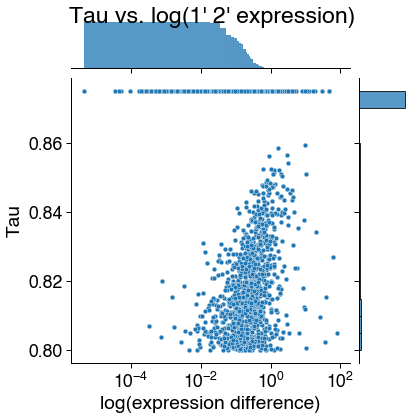

In [86]:
# relationship between difference in median CPM of 1' and 2' highest epxressed
# population per transcript vs. the tau value
g = sns.jointplot(tau_df, x='max_diffs', y='tau')
ax = g.ax_joint
ax.set(ylabel='Tau',
       xlabel='log(expression difference)',
       xscale='log')

g.fig.suptitle("Tau vs. log(1' 2' expression)")

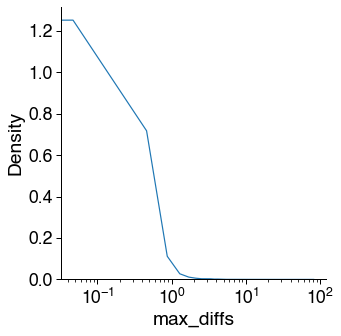

In [87]:
ax = sns.displot(tau_df, 
            x='max_diffs',
            kind='kde')
ax.set(xscale='log')

Text(0.5, 0.98, "Tau vs. log(1' 3' expression)")

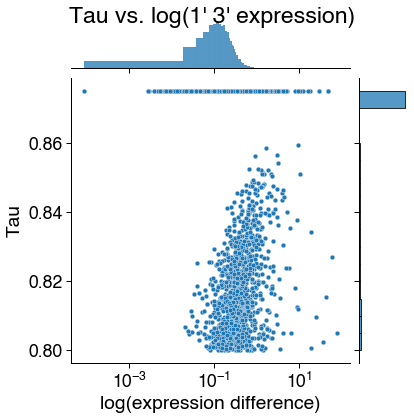

In [88]:
# relationship between difference in median CPM of 1' and 2' highest epxressed
# population per transcript vs. the tau value
g = sns.jointplot(tau_df, x='2_max_diffs', y='tau')
ax = g.ax_joint
ax.set(ylabel='Tau',
       xlabel='log(expression difference)',
       xscale='log')

g.fig.suptitle("Tau vs. log(1' 3' expression)")

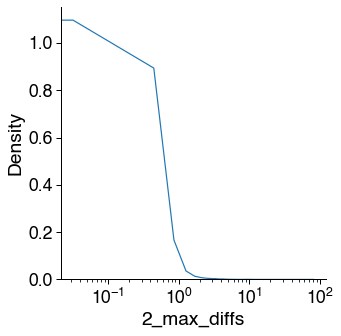

In [89]:
ax = sns.displot(tau_df, 
            x='2_max_diffs',
            kind='kde')
ax.set(xscale='log')

## pop-specific transcripts max. median values

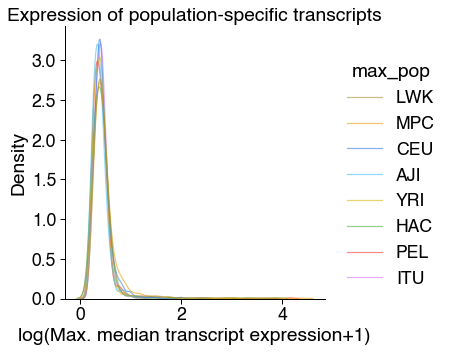

In [90]:
# merge w/ population its spec in
tau_df = tau_df_back.loc[tau_df_back['tau_pop_spec_t'] ==True]
tau_df = tau_df.merge(df[['max_val', 'max_pop', 'tid']], 
             how='left', on='tid')
tau_df['log_max_val'] = np.log(tau_df.max_val+1)

tau_df.head()
init_plot_settings(aspect='square')
c_dict, order = get_population_colors()
ax = sns.displot(tau_df, 
            x='log_max_val',
            hue='max_pop',
            palette=c_dict,
            alpha=0.6,
            kind='kde',
            common_norm=False)

ax.set(xlabel='log(Max. median transcript expression+1)',
       title='Expression of population-specific transcripts')

## Recreate the pop-specif detection plot

In [91]:
# merge w/ population its spec in
tau_df = tau_df_back.loc[tau_df_back['tau_pop_spec_t'] ==True]
tau_df = tau_df.merge(df[['max_val', 'max_pop', 'tid']], 
             how='left', on='tid')

In [92]:
tau_df.head()

,tid,tau,tau_pop_spec_t,max_val,max_pop
0,ENST00000690627.1,0.875,True,1.654284,LWK
1,transcript_10334,0.875,True,0.349953,MPC
2,transcript_12300,0.875,True,0.546844,LWK
3,ENST00000478359.5,0.875,True,0.280184,CEU
4,transcript_8852,0.875,True,0.542917,AJI


In [93]:
# get structural categories
## what structural categories are high-tau transcripts?
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [94]:
tau_df = tau_df.merge(mt_df[['isoform', 'structural_category']],
                      how='left',
                      left_on='tid',
                      right_on='isoform')

In [95]:
# replace all NANs w/ FSM because thats what they are 
# TODO fix this when have the new sqanti thing
assert len(tau_df.loc[tau_df.structural_category.isnull()]) == 0
# tau_df['structural_category'] = tau_df['structural_category'].fillna('FSM')

In [96]:
temp = tau_df[['tid', 'structural_category',
        'max_pop']].groupby(['structural_category', 'max_pop'], dropna=False).count()

In [97]:
temp = temp.reset_index()
temp.head()

,structural_category,max_pop,tid
0,Antisense,AJI,19
1,Antisense,CEU,4
2,Antisense,HAC,7
3,Antisense,ITU,19
4,Antisense,LWK,7


In [98]:
def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

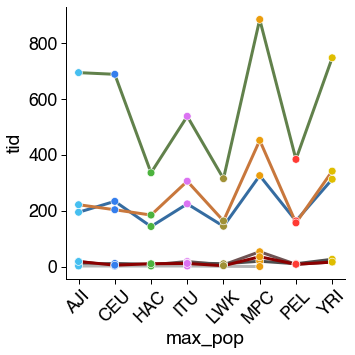

In [99]:
init_plot_settings()
c_dict, order = get_novelty_colors()
ax = sns.lineplot(temp,
    x='max_pop', y='tid', hue='structural_category',
    palette=c_dict, linewidth=3, legend=None)
c_dict, order = get_population_colors()
sns.scatterplot(temp, x='max_pop', y='tid', hue='max_pop',
    palette=c_dict, ax=ax, zorder=3,
    s=60,legend=None)
clean_figure(ax)            

## limted just to pop-spec expressed transcripts

In [100]:
tau_df = tau_df_back.loc[tau_df_back['tau_pop_spec_t'] ==True]
tau_df = tau_df.merge(df[['max_val', 'max_pop', 'tid']], 
             how='left', on='tid')

In [101]:
init_plot_settings(aspect='square')
c_dict, order = get_population_colors()
temp = tau_df[['max_pop', 'tid']].groupby('max_pop').nunique().reset_index()
temp.head()

,max_pop,tid
0,AJI,1161
1,CEU,1151
2,HAC,695
3,ITU,1117
4,LWK,646


[Text(0.5, 0, ''), Text(0, 0.5, '# population-specific transcripts')]

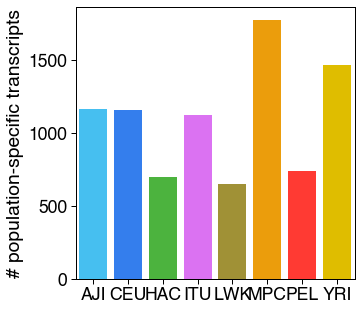

In [102]:
# number of pop-spec transcirpts / pop
ax = sns.barplot(temp, x='max_pop', y='tid',
            palette=c_dict, order=order,
           saturation=1) 
ylabel = '# population-specific transcripts'
xlabel = ''
ax.set(xlabel=xlabel, ylabel=ylabel)

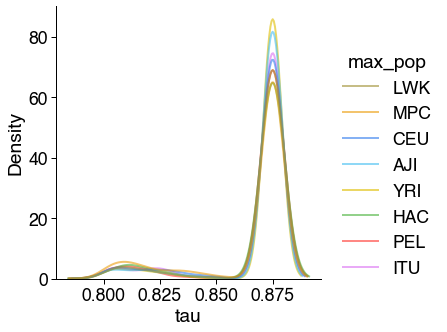

In [103]:
# are taus higher / lower for differnet pop spec transcripts 
# depending on the pop?
sns.displot(tau_df, kind='kde', 
            palette=c_dict, 
            hue='max_pop', 
            x='tau',
            common_norm=False, 
            linewidth=2,
            alpha=0.6)

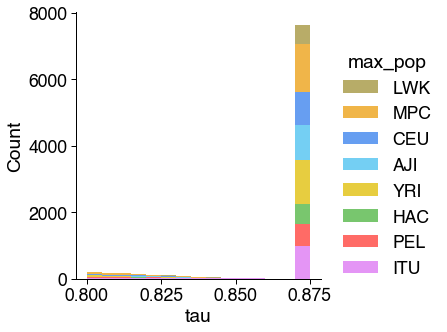

In [104]:
sns.displot(tau_df, kind='hist', 
            palette=c_dict, 
            hue='max_pop', 
            x='tau',
            multiple='stack', linewidth=False)

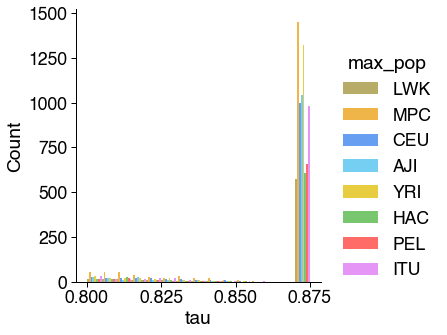

In [105]:
sns.displot(tau_df, kind='hist', 
            palette=c_dict, 
            hue='max_pop', 
            x='tau',
            multiple='dodge', linewidth=False)

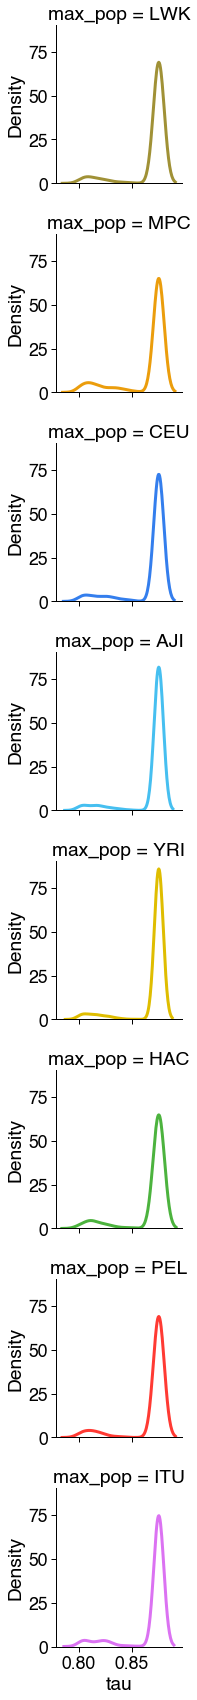

In [106]:
init_plot_settings('square')
g = sns.FacetGrid(tau_df, row='max_pop')
g.map_dataframe(sns.kdeplot, x='tau',
                hue='max_pop', palette=c_dict,
                linewidth=3)

## any transcript

In [107]:
## any transcript that is most median most highly-expressed in one pop or another
tau_df = tau_df_back.merge(df[['max_val', 'max_pop', 'tid']], 
             how='left', on='tid')

[Text(0.5, 0, ''), Text(0, 0.5, '# population-specific transcripts')]

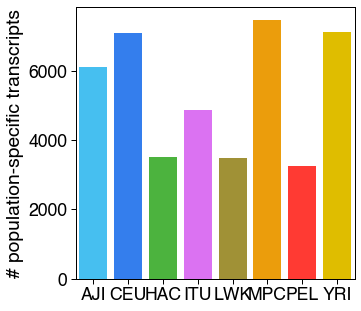

In [108]:
# number of highest-expresseed transcirpts / pop
init_plot_settings(aspect='square')
c_dict, order = get_population_colors()
temp = tau_df[['max_pop', 'tid']].groupby('max_pop').nunique().reset_index()
temp.head()
ax = sns.barplot(temp, x='max_pop', y='tid',
            palette=c_dict, order=order,
           saturation=1) 
ylabel = '# population-specific transcripts'
xlabel = ''
ax.set(xlabel=xlabel, ylabel=ylabel)

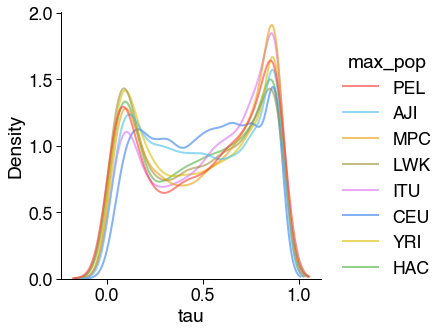

In [109]:
# are taus higher / lower for differnet pop spec transcripts 
# depending on the pop?
sns.displot(tau_df, kind='kde', 
            palette=c_dict, 
            hue='max_pop', 
            x='tau',
            common_norm=False, 
            linewidth=2,
            alpha=0.6)

In [110]:
tau_df.head()

,tid,tau,tau_pop_spec_t,max_val,max_pop
0,transcript_6675,0.701495,False,0.694056,PEL
1,transcript_6676,0.525534,False,0.850381,AJI
2,transcript_6684,0.594136,False,0.688726,AJI
3,transcript_11363,0.785230,False,0.652888,MPC
4,transcript_11368,0.694987,False,0.762286,LWK


## what if we just care about transcripts that are expressed at all in each pop?

In [111]:
# get median expression per population
# because this is what the value is computed based on 
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)

# get the median expression value across samples from the same populations
# using the median because we want to remove the effect 
# of individual samples expression patterns on the analysis
df = df.transpose()
df.reset_index(inplace=True)
df.rename({'index':'sample'}, axis=1, inplace=True)
df = df.merge(meta[['sample', 'population']], 
              how='left', on='sample')
df = df.groupby('population').median().reset_index()
# df = df.groupby('population').mean().reset_index()
df.set_index('population', inplace=True)
df.index.name = ''
df = df.transpose()


# expressed = above min cpm
df = df>=min_cpm

# get only expresesd transcript + population pairs
df = df.melt(ignore_index=False, value_name='expressed', var_name='pop')
df = df.loc[df.expressed==True]
df.reset_index(inplace=True)
df.rename({'index':'tid'}, axis=1, inplace=True)

In [112]:
# merge w/ tau df
tau_df = tau_df_back.merge(df, how='inner', on='tid')

In [113]:
tau_df.head()

,tid,tau,tau_pop_spec_t,pop,expressed
0,transcript_10289,0.228638,False,AJI,True
1,transcript_10289,0.228638,False,CEU,True
2,transcript_10289,0.228638,False,HAC,True
3,transcript_10289,0.228638,False,ITU,True
4,transcript_10289,0.228638,False,LWK,True


[Text(0.5, 0, ''),
 Text(0, 0.5, '# population-expressed\n(med. CPM>=1 transcripts')]

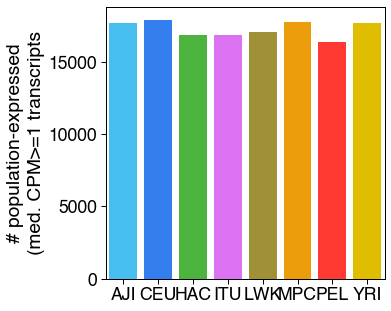

In [114]:
# number of highest-expresseed transcirpts / pop
init_plot_settings(aspect='square')
c_dict, order = get_population_colors()
temp = tau_df[['pop', 'tid']].groupby('pop').nunique().reset_index()
temp.head()
ax = sns.barplot(temp, x='pop', y='tid',
            palette=c_dict, order=order,
           saturation=1) 
ylabel = f'# population-expressed\n(med. CPM>={min_cpm} transcripts'
xlabel = ''
ax.set(xlabel=xlabel, ylabel=ylabel)

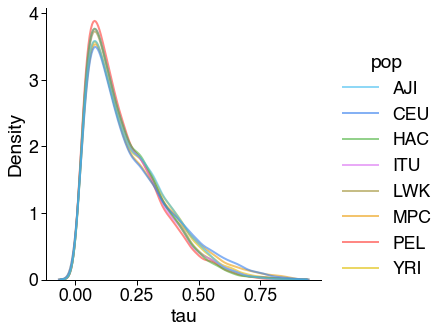

In [115]:
# are taus higher / lower for differnet pop spec transcripts 
# depending on the pop?
sns.displot(tau_df, kind='kde', 
            palette=c_dict, 
            hue='pop', 
            x='tau',
            common_norm=False, 
            linewidth=2,
            alpha=0.6)